In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('../src'))
from BasicSR import *

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import os

import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import os


In [3]:
hr_size = (120,120) 
lr_size = (60,60)

datasetPath = r"..\data\SampleDataset"
imagePaths = filter_120x120_images(datasetPath)

dataset = SRDataset(imagePaths, lr_size, hr_size)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


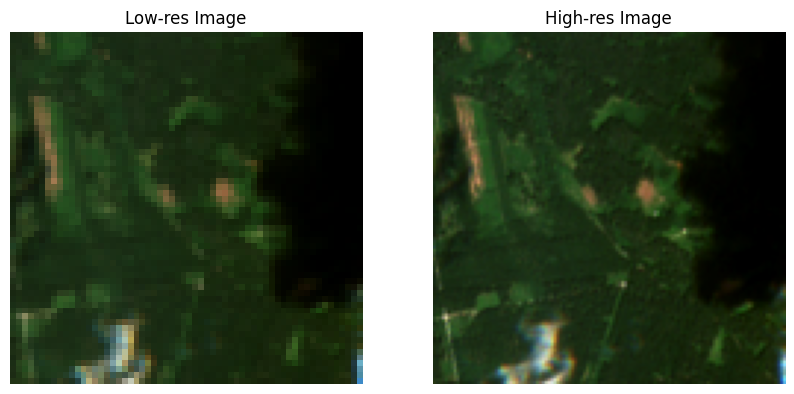

In [4]:
lr_img, hr_img, pths = next(iter(dataloader))

lr_img = lr_img.permute(0, 2, 3, 1).numpy() 
hr_img = hr_img.permute(0, 2, 3, 1).numpy() 

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(lr_img[0])  
plt.title("Low-res Image")
plt.axis('off') 

plt.subplot(1, 2, 2)
plt.imshow(hr_img[0])  
plt.title("High-res Image")
plt.axis('off') 

plt.show()


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
swin2sr_model = Swin2SR(
    img_size=60,
    patch_size=6,
    in_channels=3,
    embed_dim=768,
    depth=12,
    num_heads=12,
    scale_factor=2 
).to(device)

x = torch.randn(1, 3, 60, 60).to(device)
output = swin2sr_model(x)
print(output.shape) 


torch.Size([1, 3, 120, 120])


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm

def psnr_loss(output, target, max_pixel_value=1.0):
    mse = torch.mean((output - target) ** 2)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return -psnr  # Return negative PSNR to minimize
from torchmetrics.functional import structural_similarity_index_measure as ssim

class PSNR_SSIM_Loss(nn.Module):
    def __init__(self, alpha=0.5):
        super(PSNR_SSIM_Loss, self).__init__()
        self.alpha = alpha 
    
    def forward(self, output, target):
        psnr_value = psnr_loss(output, target)
        ssim_value = 1 - ssim(output, target)
        return self.alpha * psnr_value + (1 - self.alpha) * ssim_value
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = Swin2SR(img_size=60, patch_size=6, in_channels=3, embed_dim=768, depth=12, num_heads=12)
vit_model.to(device)
criterion = PSNR_SSIM_Loss(alpha=0.7) 
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

num_epochs = 0 # change this if you want to train

for epoch in range(num_epochs):
    vit_model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (lr_tensor, hr_tensor, pths) in enumerate(progress_bar):
        lr_tensor, hr_tensor = lr_tensor.to(device), hr_tensor.to(device)

        optimizer.zero_grad()
        outputs = vit_model(lr_tensor)

        if outputs.shape != hr_tensor.shape:
            print(f"Output shape: {outputs.shape}, HR shape: {hr_tensor.shape}")
            raise ValueError("Output shape does not match HR shape")

        loss = criterion(outputs, hr_tensor)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")


In [7]:
#torch.save(vit_model.state_dict(), "vit_model3.pth")

In [8]:
# load
vit_model = Swin2SR(img_size=60, patch_size=6, in_channels=3, embed_dim=768, depth=12, num_heads=12)

vit_model.load_state_dict(torch.load(r"..\src\checkpoints\vit_model3.pth"))

<All keys matched successfully>

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

vit_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)
mse_criterion = torch.nn.MSELoss()

visualize_super_resolve_dataloader(dataloader, vit_model, mse_criterion, device)


100%|██████████| 252/252 [00:06<00:00, 39.31it/s]

Average PSNR: 30.58
Average SSIM: 0.9099
Average MSE: 0.0010


In [10]:

# use this to make sr images
#lr_img, sr_img = super_resolve_images(dataloader, output_dir="SR_Basic", vit_model, device))